# Shoes price prediction

## Objective:

Predicting shoes price for the customers of Zshoes and deploy with the help of flask.

## Problem Statement:

Zshoes.com is one of the famous shoe manufacturers of India and has business in
almost every country in Asia and Europe. They are one of the best choices of all the
athletics and they make the best shoes for running. Due to pandemic, they are facing a
loss as Zshoes are a bit expensive. They want to know the correct price of all types of
shoes that they are manufacturing so that they won’t face any loss and at the same
time customers also buy the shoes. As a machine learning engineer, we have to build a
shoe-price prediction app that can predict the correct shoe price by taking inputs like
freight_value,payment_type, etc.

### Guidelines for Model_building.ipynb

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

### Data Understanding

In [5]:
df = pd.read_csv('product_data.csv')

In [16]:
# Getting the first few data points
df.head()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,1,58.90,13.29,1,1,2,72.19
1,1,239.90,19.93,1,1,3,259.83
2,1,199.00,17.87,1,1,5,216.87
3,1,12.99,12.79,1,1,2,25.78
4,1,199.90,18.14,1,1,3,218.04


 Price is the target column (dependent) (y) rest are the independent variables

In [18]:
# Getting the shape of the data(rows and columns)
df.shape

(101335, 7)

Dataset having 101335 rows and 7 columns

In [19]:
# Getting basic data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101335 entries, 0 to 101334
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_item_id         101335 non-null  int64  
 1   price                 101335 non-null  float64
 2   freight_value         101335 non-null  float64
 3   payment_sequential    101335 non-null  int64  
 4   payment_type          101335 non-null  int64  
 5   payment_installments  101335 non-null  int64  
 6   payment_value         101335 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.4 MB


In [20]:
# Five point summary of the data
df.describe()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
count,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000
mean,1.205280,79.818332,16.126716,1.089495,1.352040,2.671703,124.124508
std,0.715244,56.057932,5.943237,0.689100,0.652362,2.524321,124.418064
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,35.990000,12.690000,1.000000,1.000000,1.000000,55.550000
50%,1.000000,63.900000,15.470000,1.000000,1.000000,1.000000,95.400000
75%,1.000000,109.900000,18.670000,1.000000,2.000000,3.000000,155.840000
max,21.000000,270.000000,36.000000,26.000000,4.000000,24.000000,3195.730000


In [21]:
df[df['freight_value'] == 0]['payment_sequential'].value_counts()

1    382
2      3
6      1
5      1
4      1
3      1
Name: payment_sequential, dtype: int64

### EDA

 As we mentioned above there is no null values in the data. Hence no need to check for it

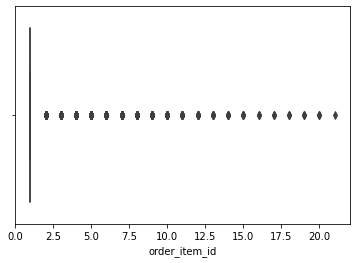

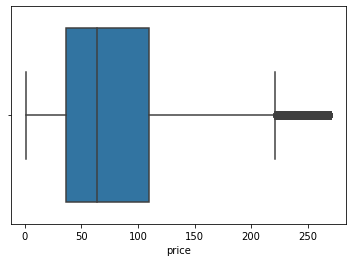

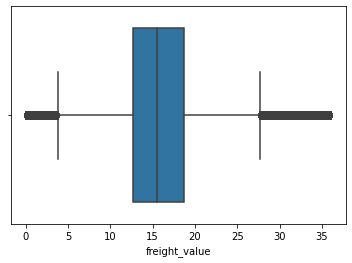

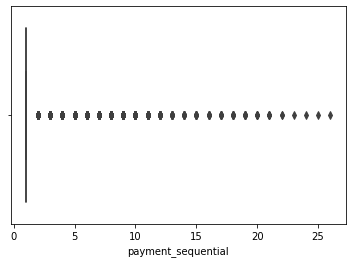

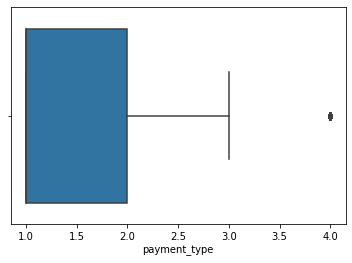

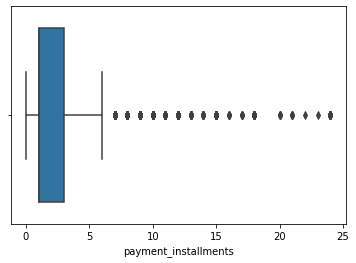

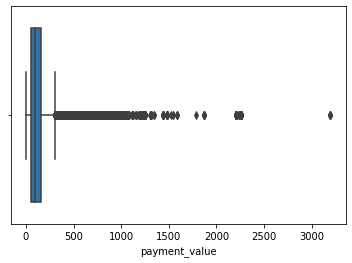

In [24]:
# Checking for outliers

for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

As we can see presence of outliers which may affect on performance of models.Hence need to treat it.

In [25]:
df.columns

Index(['order_item_id', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [26]:
# We can clearly see there are outliers. So we are moving forward with treating outliers
num_cols = df[['price','payment_installments','freight_value','payment_value']]
for col in num_cols.columns:
  q1 = num_cols[col].quantile(0.25)
  q3 = num_cols[col].quantile(0.75)
  iqr = q3-q1
  ll = q1 - (1.5*iqr)
  ul = q3 + (1.5*iqr)
  for ind in df[col].index:
    if df.loc[ind,col] < ll :
      df.loc[ind,col] = ll
    elif df.loc[ind,col] > ul :
      df.loc[ind,col] = ul


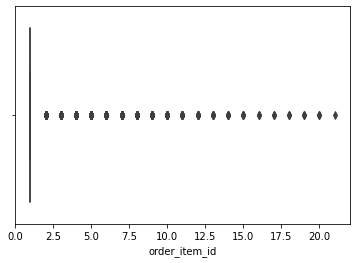

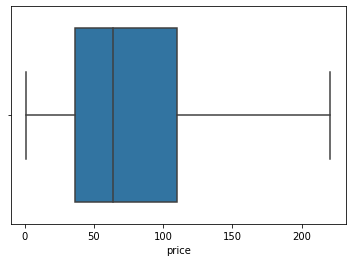

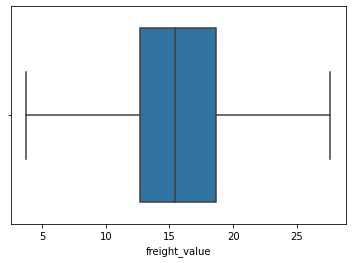

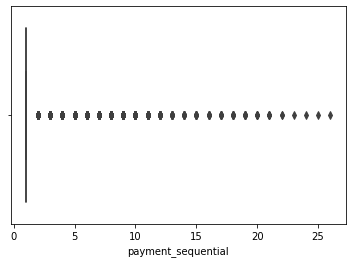

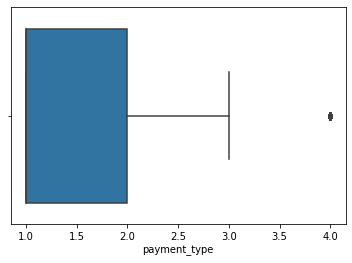

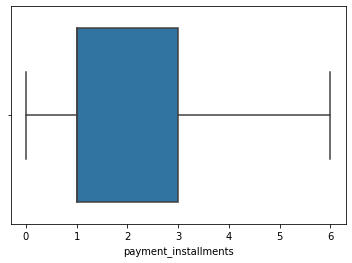

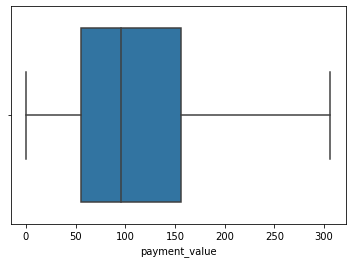

In [27]:
# Boxplot after outlier treatment
for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

 Outliers has been treated

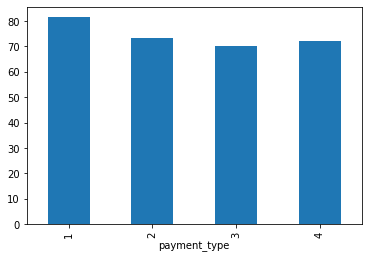

In [29]:
# Average price for each payment type
df.groupby('payment_type')['price'].mean().plot(kind='bar')

 Most payment is coming from payment type 1 gateway

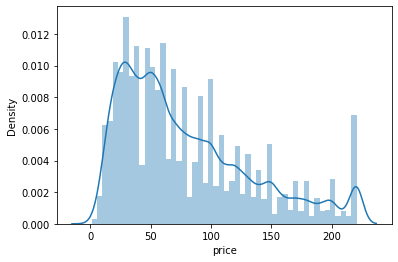

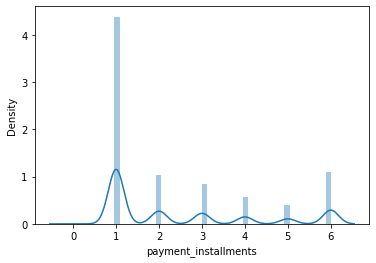

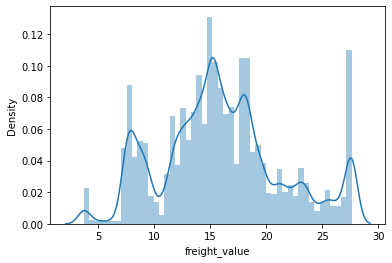

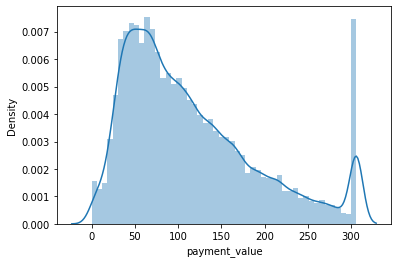

In [31]:
# Checking for skewness with distribution plot
for i in num_cols:
  sns.distplot(df[i])
  plt.show()

 Freight has a good distribution shape whereas payment value is slightly right skewed

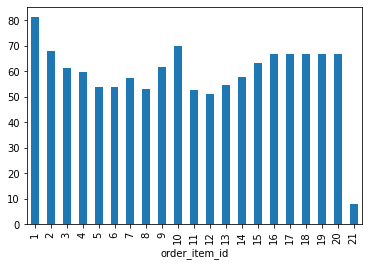

In [33]:
# Order id wise price distribution
df.groupby('order_item_id')['price'].mean().plot(kind = 'bar')

 Average order item id 1 is the highest

### Model Building and Evaluation

In [35]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import scipy.stats as stats

#### Splitting data into x and y

Remove unwanted column order_item_id

In [36]:
df = df.drop(columns = ['order_item_id'])

In [37]:
x = df.drop(columns=['price'])
y = df['price']

#### Assumptions prior to building a linear model

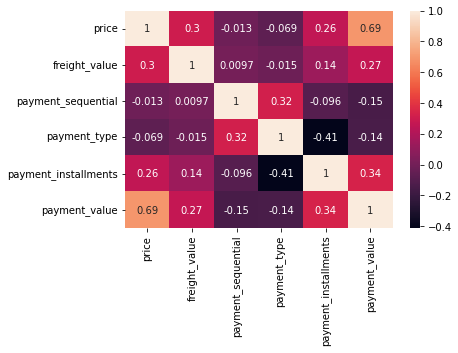

In [38]:
# Checking the relationship between target and independent variables
sns.heatmap(df.corr(),annot=True)

Apart from payment value, none of the variables have correlation with the target variable which is price

In [40]:
# Normality of the target (As the data points are above 5000 we just take a random sample of 1000 
# inorder to validate the normality)
# Ho : data is normal
# Ha : data is not normal

# hypothesis testing function
def hyp_testing(pval,sig_lvl):
  if pval>sig_lvl:
    return 'Fail to reject Ho'
  else:
    return 'Ho rejected'

sh = y.sample(1000,random_state = 7)
w,pval = stats.shapiro(sh)
print(pval)
print(hyp_testing(pval,0.05))

2.048851039499679e-24
Ho rejected


 Target variable is not normal

In [42]:
# Multi-Collinearity
vif = pd.DataFrame()
vif['Factor'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
vif['Features'] = df.columns
vif.sort_values(by = 'Factor',ascending=False)

,Factor,Features
1,7.501890,freight_value
5,6.746151,payment_value
0,6.301341,price
3,5.062311,payment_type
2,3.836369,payment_sequential
4,3.130878,payment_installments


 Multicollinearity is at an acceptable level(eventhough above 5 but still highest factor below 10)

#### Train Test Split

In [44]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=7)

#### Model Building

In [45]:
# Base model LinearRegression
lr = LinearRegression()
base = lr.fit(xtrain,ytrain)
ypred = base.predict(xtest)

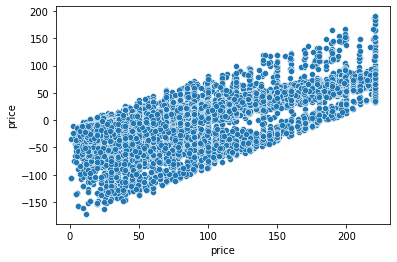

In [46]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [47]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=lr,X=x,y=y,scoring = 'r2',cv=kf)
r2_lr = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_lr = 1 - ((1-r2_lr)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=lr,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_lr = np.abs(np.mean(mse))
rmse_lr = np.sqrt(mse_lr)
print(r2_lr)
print(adj_r2_lr)
print(rmse_lr) 

0.5042723672590249
0.5042479059679463
38.281840636905926


 Durbin-Watson is less than 2 which means data have positive auto-correlation

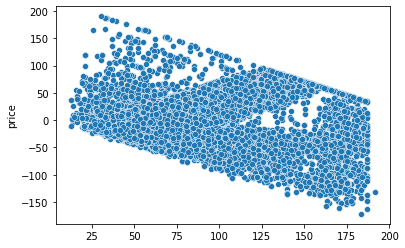

In [50]:
# Checking for Heteroscedasticity(residual vs fitted plot)
r = ytest-ypred
sns.scatterplot(x = ypred, y = r)
plt.show()

It is clearly showing a funnel shaped distribution which means the data is not homoskedastic

In [53]:
#2nd model - DecisionTreeRegressor
dt = DecisionTreeRegressor()
model_v1 = dt.fit(xtrain,ytrain)
ypred =  model_v1.predict(xtest)

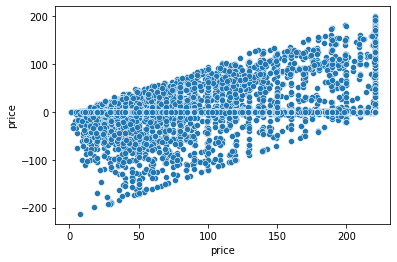

In [54]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [55]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=dt,X=x,y=y,scoring = 'r2',cv=kf)
r2_dt = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_dt = 1 - ((1-r2_dt)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=dt,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_dt = np.abs(np.mean(mse))
rmse_dt = np.sqrt(mse_dt)
print(r2_dt)
print(adj_r2_dt)
print(rmse_dt) 

0.7704530739531773
0.7704417471402192
37.16442024921196


In [56]:
# The results are much better now , we can do feature selection on the data using this model
sf = sfs(dt,n_features_to_select=2,scoring = 'neg_mean_squared_error',cv=k)
feat = sf.fit(x,y)

In [57]:
feat.get_feature_names_out()

array(['freight_value', 'payment_value'], dtype=object)

In [58]:
#These are the most important features,let's build a model based on this features
new_feat = x[['freight_value','payment_value']]

#Finding r2, mse and rmse using cross validation on new features
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=dt,X=new_feat,y=y,scoring = 'r2',cv=kf)
r2_dt = np.mean(r2)
n = new_feat.shape[0]
k = new_feat.shape[1]
adj_r2_dt = 1 - ((1-r2_dt)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=dt,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_dt = np.abs(np.mean(mse))
rmse_dt = np.sqrt(mse_dt)
print(r2_dt)
print(adj_r2_dt)
print(rmse_dt) 

0.7883859641735619
0.7883817875257937
38.58140257605853


 feature selection didn't do much improvement

In [60]:
# Model3 - RandomForest
rf = RandomForestRegressor()
model_v2 = rf.fit(xtrain,ytrain)
ypred =  model_v2.predict(xtest)

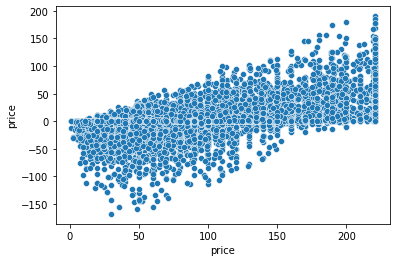

In [61]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [62]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=rf,X=x,y=y,scoring = 'r2',cv=kf)
r2_rf = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_rf = 1 - ((1-r2_rf)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=rf,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_rf = np.abs(np.mean(mse))
rmse_rf = np.sqrt(mse_rf)
print(r2_rf)
print(adj_r2_rf)
print(rmse_rf) 

0.8468922128366156
0.8468846578529898
30.45128775082788


 This is more improved comparing to decision tree

In [64]:
# Model4 - AdaBoostRegressor
ada = AdaBoostRegressor()
model_v3 = rf.fit(xtrain,ytrain)
ypred =  model_v3.predict(xtest)

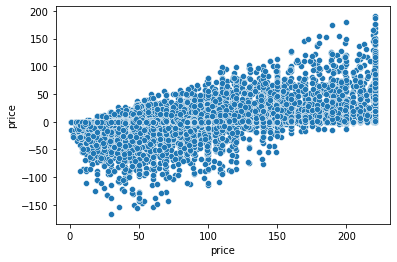

In [65]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [66]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=ada,X=x,y=y,scoring = 'r2',cv=kf)
r2_ada = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_ada = 1 - ((1-r2_ada)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=ada,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_ada = np.abs(np.mean(mse))
rmse_ada = np.sqrt(mse_ada)
print(r2_ada)
print(adj_r2_ada)
print(rmse_ada) 

0.5273295281374827
0.5273062045839165
36.907223821153615


In [68]:
# Model 5 - XGBoostRegressor

xgb = XGBRegressor(verbosity=0)
model_v4 = xgb.fit(xtrain,ytrain)
ypred =  model_v4.predict(xtest)

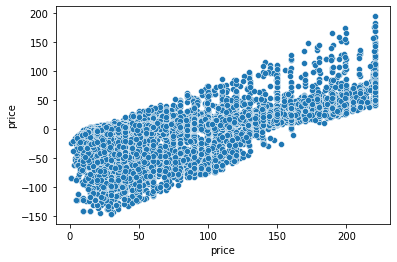

In [69]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [70]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=xgb,X=x,y=y,scoring = 'r2',cv=kf)
r2_xgb = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_xgb = 1 - ((1-r2_xgb)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=xgb,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_xgb = np.abs(np.mean(mse))
rmse_xgb = np.sqrt(mse_xgb)
print(r2_xgb)
print(adj_r2_xgb)
print(rmse_xgb) 

0.6396483934715034
0.6396306122042192
32.87196088205303


 It did improved upon adaboost but fell short of random forest

In [72]:
# Let's see which models we can use for stacking model
results = pd.DataFrame({'Models':['Linear Regression','Decision Tree','Random Forest','AdaBoosting','XGBoosting'],
                        'R-Squared':[r2_lr,r2_dt,r2_rf,r2_ada,r2_xgb],
                        'Adj. R-Squared':[adj_r2_lr,adj_r2_dt,adj_r2_rf,adj_r2_ada,adj_r2_xgb],
                        'MSE':[mse_lr,mse_dt,mse_rf,mse_ada,mse_xgb],
                        'RMSE':[rmse_lr,rmse_dt,rmse_rf,rmse_ada,rmse_xgb]})
results.sort_values(by='RMSE')

,Models,R-Squared,Adj. R-Squared,MSE,RMSE
2,Random Forest,0.846892,0.846885,927.280926,30.451288
4,XGBoosting,0.639648,0.639631,1080.565812,32.871961
3,AdaBoosting,0.527330,0.527306,1362.143170,36.907224
0,Linear Regression,0.504272,0.504248,1465.499323,38.281841
1,Decision Tree,0.788386,0.788382,1488.524625,38.581403


In [74]:
# Model6 - StackingRegressor
ada = AdaBoostRegressor()
xgb = XGBRegressor(verbosity=0)
rf = RandomForestRegressor()
est = [('Xgboost',xgb),('Adaboost',ada)]
stack = StackingRegressor(estimators=est,final_estimator=rf,cv=5)
model_v5 = stack.fit(xtrain,ytrain)
ypred = model_v5.predict(xtest)

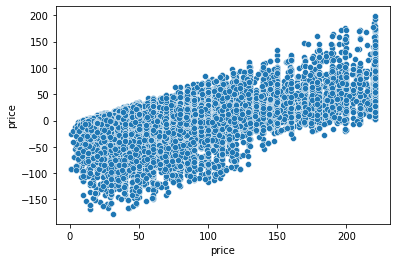

In [75]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [76]:
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=stack,X=x,y=y,scoring = 'r2',cv=kf)
r2_stack = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_stack = 1 - ((1-r2_stack)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=stack,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_stack = np.abs(np.mean(mse))
rmse_stack = np.sqrt(mse_stack)
print(r2_stack)
print(adj_r2_stack)
print(rmse_stack) 

0.5296105780899584
0.5295873670930122
37.411762856274734


In [77]:
# Model7- Voting Regressor

ada = AdaBoostRegressor()
xgb = XGBRegressor(verbosity=0)
rf = RandomForestRegressor()
est = [('Xgboost',xgb),('Adaboost',ada),('Random Forest',rf)]
vote = VotingRegressor(estimators=est)
model_v6 = vote.fit(xtrain,ytrain)
ypred = model_v6.predict(xtest)

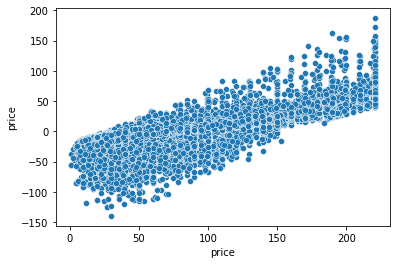

In [78]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [79]:
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=vote,X=x,y=y,scoring = 'r2',cv=kf)
r2_vote = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_vote = 1 - ((1-r2_vote)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=vote,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_vote = np.abs(np.mean(mse))
rmse_vote = np.sqrt(mse_vote)
print(r2_vote)
print(adj_r2_vote)
print(rmse_vote) 

0.7404284509177871
0.7404156425633632
31.268215563206148


In [80]:
# Final Results
final_res = pd.DataFrame({'Models':['Linear Regression','Decision Tree','Random Forest','AdaBoosting',
                                  'XGBoosting','Stacking Regressor','Voting Regressor'],
                        'R-Squared':[r2_lr,r2_dt,r2_rf,r2_ada,r2_xgb,r2_stack,r2_vote],
                        'Adj. R-Squared':[adj_r2_lr,adj_r2_dt,adj_r2_rf,adj_r2_ada,adj_r2_xgb,adj_r2_stack,
                                          adj_r2_vote],
                        'MSE':[mse_lr,mse_dt,mse_rf,mse_ada,mse_xgb,mse_stack,mse_vote],
                        'RMSE':[rmse_lr,rmse_dt,rmse_rf,rmse_ada,rmse_xgb,rmse_stack,rmse_vote]})
final_res.sort_values(by='RMSE')

,Models,R-Squared,Adj. R-Squared,MSE,RMSE
2,Random Forest,0.846892,0.846885,927.280926,30.451288
6,Voting Regressor,0.740428,0.740416,977.701305,31.268216
4,XGBoosting,0.639648,0.639631,1080.565812,32.871961
3,AdaBoosting,0.527330,0.527306,1362.143170,36.907224
5,Stacking Regressor,0.529611,0.529587,1399.640000,37.411763
0,Linear Regression,0.504272,0.504248,1465.499323,38.281841
1,Decision Tree,0.788386,0.788382,1488.524625,38.581403


## Conclusion

### Random Forest model is the best model for building a price prediction application 

Save the best model

In [6]:
import pickle
save the model using pickle to disk
filename='finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))


Load the model

In [7]:
loaded_model=pickle.load(open(filename,'rb'))

# ----------------------------------------------------------------------------------------------------------------- 